#### 데이터를 20분 단위로 묶고 3분 뒤
#### d_model => 32 -> 128

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [20]:
# 1. 데이터 전처리
def create_classification_targets(data, columns, window_size=20, pred_offset=1):
    X = []
    y = []
    for i in range(len(data) - window_size - pred_offset + 1):
        # 10분 동안의 Close와 Volume 데이터
        X.append(data.iloc[i:i+window_size][columns].values)
        # 3분 뒤의 Close 가격 변화에 따른 클래스 설정
        future_close = data.iloc[i+window_size+pred_offset-1]['Close']
        current_close = data.iloc[i+window_size-1]['Close']
        
        # 가격 변화에 따라 클래스 설정: 상승(2), 보합(1), 하락(0)
        if future_close > current_close:
            y.append(2)  # 상승
        elif future_close < current_close:
            y.append(0)  # 하락
        else:
            y.append(1)  # 보합
    return np.array(X), np.array(y)

# 데이터 불러오기 및 전처리
data = pd.read_csv('./000660.csv', parse_dates=['Unnamed: 0'])
data = data.rename(columns={'Unnamed: 0': 'Time', '매수량': 'BuyVolume', '매도량': 'SellVolume', '종가': 'Close', '저가': 'Low'})
data['Power'] = data['BuyVolume'] - data['SellVolume']
columns = ['Close', 'Power', 'Low']
data = data[columns].dropna()

# 데이터 정규화
scaler = RobustScaler()
# scaled_data = scaler.fit_transform(data)
# scaled_df = pd.DataFrame(scaled_data, columns=columns)

X, y = create_classification_targets(data, columns)

X_scaled = np.array([scaler.fit_transform(sample) for sample in X])

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)  # (samples, 10, 2)
print(y_train.shape)  # (samples,)

(149456, 20, 3)
(149456,)


In [21]:
X.shape
X.shape[1:]

(20, 3)

In [22]:
# y 클래스 데이터 분포 확인
print(np.bincount(y_train))

[44424 61574 43458]


In [23]:
# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [24]:
# 2. Positional Encoding 구현
def positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    # 짝수 인덱스에 대해 sin 적용
    sines = np.sin(angle_rads[:, 0::2])

    # 홀수 인덱스에 대해 cos 적용
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    return pos_encoding

def add_positional_encoding(inputs, max_len, d_model):
    pos_encoding = positional_encoding(max_len, d_model)
    pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
    
    pos_encoded_inputs = inputs + pos_encoding[:tf.shape(inputs)[1], :]
    return pos_encoded_inputs

# 3. Transformer 블록 구현
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu", kernel_initializer='he_normal'), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output1 = self.att1(inputs, inputs)
        attn_output1 = self.dropout1(attn_output1)
        out1 = self.layernorm1(inputs + attn_output1)
        # attn_output2 = self.att2(out1, out1)
        # attn_output2 = self.dropout2(attn_output2)
        # out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout1(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

# 4. Transformer 모델 구성
def create_transformer_model(input_shape, num_heads, ff_dim, d_model, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # 임베딩 및 위치 인코딩
    embedding_layer = layers.Dense(d_model, kernel_initializer='he_normal')(inputs)
    pos_encoded_inputs = add_positional_encoding(embedding_layer, max_len=input_shape[0], d_model=d_model)

    # Transformer 블록 적용
    transformer_block = TransformerBlock(d_model, num_heads, ff_dim)
    x = transformer_block(pos_encoded_inputs)
    
    # 출력 레이어
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="gelu", kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [25]:
# 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_5.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.9, 
    patience=50, 
    min_lr=0.00001
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [26]:
# 5. 모델 생성 및 학습
input_shape = X.shape[1:]  # 10분 동안의 데이터 
model = create_transformer_model(input_shape, num_heads=4, ff_dim=128, d_model=128, num_classes=3)

# 모델 컴파일
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 모델 학습
history = model.fit(X_train, 
                    y_train, 
                    epochs=1000, 
                    batch_size=128, 
                    validation_data=(X_test, y_test), 
                    class_weight=class_weights_dict,
                    callbacks=callbacks
                    )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 3)]      0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 20, 128)      512         ['input_3[0][0]']                
                                                                                                  
 tf.compat.v1.shape_2 (TFOpLamb  (3,)                0           ['dense_10[0][0]']               
 da)                                                                                              
                                                                                                  
 tf.__operators__.getitem_2 (Sl  ()                  0           ['tf.compat.v1.shape_2[0][0

In [27]:
# 성능 평가 지표
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

1168/1168 [==============================] - 6s 5ms/step
              precision    recall  f1-score   support

           0       0.33      0.13      0.19     11027
           1       0.42      0.90      0.57     15377
           2       0.00      0.00      0.00     10960

    accuracy                           0.41     37364
   macro avg       0.25      0.34      0.25     37364
weighted avg       0.27      0.41      0.29     37364



c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

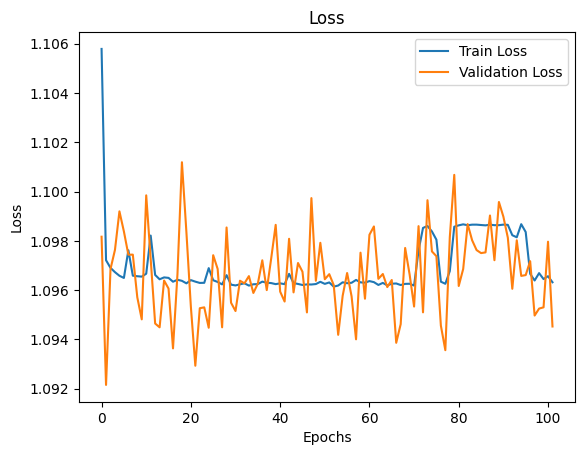

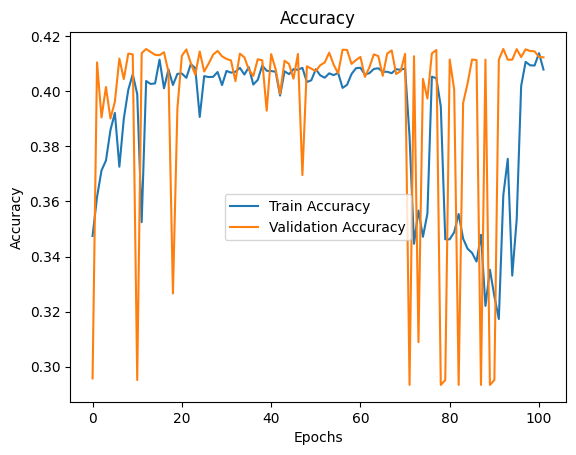

In [28]:
import matplotlib.pyplot as plt

# 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
